<center>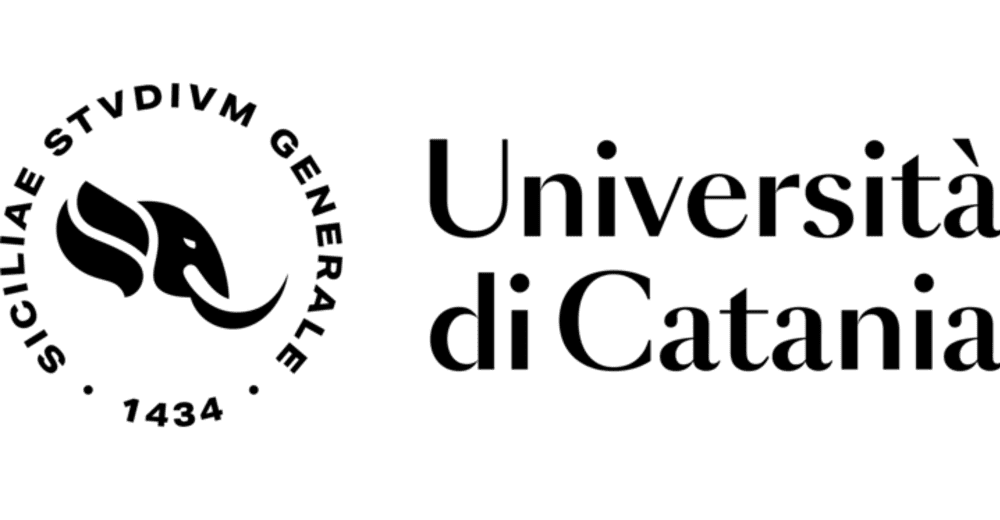

<center><h1>DATA SCIENCE FOR MANAGEMENT - LM91</h1><br />
<h1>DICOM to JPG</h1>

## 1. Introduction
This script converts DICOM slices from CT scan to JPG, in particular converts CT scans from patients of Policlinico di Catania (Dr. Palmucci) to be used as prediction set for classification of Covid-19 cases.

Data have been "anonymized" during the process using an incremental folder name and deleting all the metadata, the only possibility to check the patient and the corresponding ct scan is to own Dicom files or the .csv with the associations.

## 1.1 The DICOM file
DICOM is the de-facto file standard in medical imaging. The unit of measurement in CT scans is the Hounsfield Unit (HU), which is a measure of radiodensity.

What this script does is to convert Dicom files to JPG taking into consideration the Hounsfield Unit, some scanners have cylindrical scanning bounds, but the output image is square so pixels that fall outside of these bounds get the fixed value -2000, so there will be a resampling from 0 to 255. 

## 2. Required libraries

In [1]:
%matplotlib inline
from IPython.display import clear_output

import os
import sys
import glob
import re
import time

import pydicom

from PIL import Image
import matplotlib.pyplot as plt

import numpy as np
import cv2 as cv
import pydicom as PDCM

## 3. The script
This script was written by Abubakr Shafique (abubakr.shafique@gmail.com) - [Link to GitHub page](https://github.com/abubakr-shafique/Dicom_to_Image-Python)

<span style="color:red">**Please note: There is the probability that a patient could have done multiple ct scans**</span>

In [135]:
def Dicom_to_Image(Path):
    DCM_Img = PDCM.read_file(Path)

    rows = DCM_Img.get(0x00280010).value #Get number of rows from tag (0028, 0010)
    cols = DCM_Img.get(0x00280011).value #Get number of cols from tag (0028, 0011)

    Instance_Number = int(DCM_Img.get(0x00200013).value) #Get actual slice instance number from tag (0020, 0013)

    Window_Center = int(DCM_Img.get(0x00281050).value) #Get window center from tag (0028, 1050)
    Window_Width = int(DCM_Img.get(0x00281051).value) #Get window width from tag (0028, 1051)

    Window_Max = int(Window_Center + Window_Width / 2)
    Window_Min = int(Window_Center - Window_Width / 2)

    if (DCM_Img.get(0x00281052) is None):
        Rescale_Intercept = 0
    else:
        Rescale_Intercept = int(DCM_Img.get(0x00281052).value)

    if (DCM_Img.get(0x00281053) is None):
        Rescale_Slope = 1
    else:
        Rescale_Slope = int(DCM_Img.get(0x00281053).value)

    New_Img = np.zeros((rows, cols), np.uint8)
    Pixels = DCM_Img.pixel_array

    for i in range(0, rows):
        for j in range(0, cols):
            Pix_Val = Pixels[i][j]
            Rescale_Pix_Val = Pix_Val * Rescale_Slope + Rescale_Intercept

            if (Rescale_Pix_Val > Window_Max): #if intensity is greater than max window
                New_Img[i][j] = 255
            elif (Rescale_Pix_Val < Window_Min): #if intensity is less than min window
                New_Img[i][j] = 0
            else:
                New_Img[i][j] = int(((Rescale_Pix_Val - Window_Min) / (Window_Max - Window_Min)) * 255) #Normalize the intensities

    return New_Img, Instance_Number

Here we set the directory of Dicom files and the destination of the converted files, patients' name will be "anonymized" into an incremental number of ct_scan folder. The association within patient name and the new folder is saved in a .csv file.

In [136]:
dir_path = 'D:/dati_palmucci/'
destination_path = 'D:/dati_palmucci_pred/'

patients = os.listdir(dir_path)
Input_Folder = []
for patient in patients:
    Input_Folder.extend(glob.glob(dir_path + patient + '/**/**/unnamed - 2', recursive=False))
    Input_Folder.extend(glob.glob(dir_path + patient + '/**/**/unnamed - 3', recursive=False))
    Input_Folder.extend(glob.glob(dir_path + patient + '/**/**/unnamed - 4', recursive=False))
    Input_Folder.extend(glob.glob(dir_path + patient + '/**/**/unnamed - 5', recursive=False))
    Input_Folder.extend(glob.glob(dir_path + patient + '/**/**/Polmone Lung 2.0 - 4', recursive=False))
    Input_Folder.extend(glob.glob(dir_path + patient + '/**/**/HRCT Spirale - 2', recursive=False))
    Input_Folder.extend(glob.glob(dir_path + patient + '/**/**/HRCT Spirale - 4', recursive=False))

j = 0
pathname_patient = []
ct_scan_list = []
for Input in Input_Folder:
    # List all the dicom files in the patient folder
    Input_Image_List = os.listdir(Input)
    
    # Create folder with incremental name as ct_scan_{j}
    folder_name = f'ct_scan_{j}'
    j += 1
    os.mkdir(destination_path + folder_name)
    
    # Associate the pathname of the folder of the patient to the output name foler
    pathname_patient.append(Input)
    ct_scan_list.append(folder_name)
  
    Output_Folder = os.path.join(destination_path, folder_name)
    
    for i in range(0, len(Input_Image_List)):
        Output_Image, Instance_Number = Dicom_to_Image(Input + '/' + Input_Image_List[i])
        cv.imwrite(Output_Folder + '/' + str(Instance_Number - 1) + '.jpg', Output_Image)

Here we save the name of the folder of Dicom files to the new Jpg files in a .csv file:

In [139]:
path_patient_ct_scan = { "Path": pathname_patient, "Folder name": ct_scan_list}
path_patient_ct_scan = pd.DataFrame(path_patient_ct_scan)
path_patient_ct_scan.to_csv('path_patient_ct_scan.csv', index=False)

## 3.1 Check if data are corrupted
Here we check if converted files are too small, this will help us to avoid problems during the prediction:

In [142]:
size_file = list()
path_file = []

# Get a list of files (file paths) in the given directory 
list_of_files = filter(os.path.isfile, glob.glob(destination_path + '/**/*', recursive=True))

# get list of ffiles with size
files_with_size = [(file_path, os.stat(file_path).st_size) for file_path in list_of_files]

files_with_size = pd.DataFrame(files_with_size)

In [143]:
files_with_size.sort_values(by=[1], ascending = True).head(20)

,0,1
13322,D:/dati_palmucci_pred\ct_scan_48\0.jpg,32097
13323,D:/dati_palmucci_pred\ct_scan_48\1.jpg,32496
13434,D:/dati_palmucci_pred\ct_scan_48\2.jpg,32850
13541,D:/dati_palmucci_pred\ct_scan_48\3.jpg,33179
13552,D:/dati_palmucci_pred\ct_scan_48\4.jpg,33543
13563,D:/dati_palmucci_pred\ct_scan_48\5.jpg,34191
11061,D:/dati_palmucci_pred\ct_scan_41\0.jpg,34203
11062,D:/dati_palmucci_pred\ct_scan_41\1.jpg,34677
13574,D:/dati_palmucci_pred\ct_scan_48\6.jpg,34790
11173,D:/dati_palmucci_pred\ct_scan_41\2.jpg,35359


Files have not a small size, so the dataset is not corrupted in some way.

## 3.2 Manually checking the data
Manually checking the data allowed us to find some inconsistencies, for example there are ct scans that are color inverted and we do not need them:

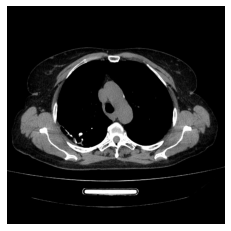

In [4]:
img = cv.imread(destination_path + '/ct_scan_2/100.jpg')[:,:,::-1]
plt.axis("off")
plt.imshow(img)

We can remove ct_scan_2, ct_scan_4, ct_scan_6, ct_scan_29, ct_scan_38, ct_scan_41 and ct_scan_48:

In [ ]:
!rm -rf D:/dati_palmucci_pred/ct_scan_2
!rm -rf D:/dati_palmucci_pred/ct_scan_4
!rm -rf D:/dati_palmucci_pred/ct_scan_6
!rm -rf D:/dati_palmucci_pred/ct_scan_29
!rm -rf D:/dati_palmucci_pred/ct_scan_38
!rm -rf D:/dati_palmucci_pred/ct_scan_41
!rm -rf D:/dati_palmucci_pred/ct_scan_48

## 3.3 Dataset composition
Here we show the number of patients, slices and average number of slices per patient:

In [6]:
patients = len(os.listdir(destination_path))
print("Number of patients: ", patients)
slices = sum(len(files) for _, _, files in os.walk(destination_path))
print("Total number of slices: ", slices)
avg_slices = round(slices/patients)
print("Average number of slices per patient: ", avg_slices)

Number of patients:  49
Total number of slices:  14635
Average number of slices per patient:  299


## 3.4 An example
Here we show a set of ct scan slices:

In [159]:
# A function to natural sort files inside the ct scan folder
def natural_sort(l): 
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(l, key=alphanum_key)

In [179]:
filename_slices = [file for _, _, file in os.walk('D:/dati_palmucci_pred/ct_scan_21')]
filename_slices = natural_sort(filename_slices[0])

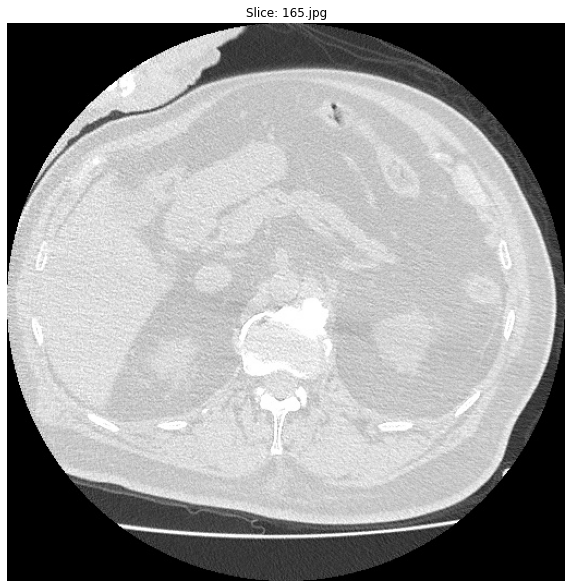

In [182]:
plt.figure()
for k in range(len(filename_slices)):
    img = cv.imread('D:/dati_palmucci_pred/ct_scan_21/'+filename_slices[k])[:,:,::-1]   # Reads an image in the BGR format to RGB
    
    fig = plt.figure(figsize=(10,15))
    plt.axis("off")
    plt.imshow(img)
    plt.title(f'Slice: %s' %filename_slices[k])
    plt.show()
    
    time.sleep(0.05)
    
    clear_output(wait=True)